## Import Libraries

In [9]:
import pandas as pd
import json
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download necessary NLTK data
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the Reddit Data

In [18]:
import pandas as pd
import json

# Load JSON data
with open('r_politics_last_30_days_posts_and_comments.json', 'r') as f:
    reddit_data = json.load(f)

# Function to extract text from a post and its nested comments
def extract_text_from_post(post):
    title = post.get('title', '')
    comments = post.get('comments', [])
    comment_bodies = ' '.join([comment.get('body', '') for comment in comments if 'body' in comment])
    return title + ' ' + comment_bodies

# Apply the function to the data
df = pd.json_normalize(reddit_data)
df['text'] = df.apply(lambda row: extract_text_from_post(row), axis=1)

# Now 'df' contains a new column 'text' with combined post titles and comment bodies
print(df[['title', 'text']].head())

                                               title  \
0  The Danger Is Greater Than in 2020. Be Prepare...   
1  Judge Blocks Hand-Counting of Election Ballots...   
2               Trump: GOP the Party of Common Sense   
3  Trump’s campaign has spent a whopping amount o...   
4  More Than 165 Lawsuits Are Already Shaping the...   

                                                text  
0  The Danger Is Greater Than in 2020. Be Prepare...  
1  Judge Blocks Hand-Counting of Election Ballots...  
2  Trump: GOP the Party of Common Sense \nAs a re...  
3  Trump’s campaign has spent a whopping amount o...  
4  More Than 165 Lawsuits Are Already Shaping the...  


In [22]:
print(df['text'].iloc[0]) # prints the combined text of post and its comments for 1st row

The Danger Is Greater Than in 2020. Be Prepared. -- A citizen’s guide to defending the 2024 election 
As a reminder, this subreddit [is for civil discussion.](/r/politics/wiki/index#wiki_be_civil)

In general, be courteous to others. Debate/discuss/argue the merits of ideas, don't attack people. Personal insults, shill or troll accusations, hate speech, any suggestion or support of harm, violence, or death, and other rule violations can result in a permanent ban. 

If you see comments in violation of our rules, please report them.

 For those who have questions regarding any media outlets being posted on this subreddit, please click [here](https://www.reddit.com/r/politics/wiki/approveddomainslist) to review our details as to our approved domains list and outlet criteria.
 
 We are actively looking for new moderators.  If you have any interest in helping to make this subreddit a place for quality discussion, please fill out [this form](https://docs.google.com/forms/d/1y2swHD0KXFhStGFjW

## Data Preprocessing

In [24]:
# Define a function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    return text

# Apply the cleaning function
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(str(x)))

# Tokenize, remove stopwords, and perform stemming
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and stem words
    return ' '.join(set(tokens))  # Use set to remove duplicates

df['processed_text'] = df['cleaned_text'].apply(lambda x: preprocess_text(x))

## Topic Modelling with LDA

In [29]:
# Convert the processed text into a document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['processed_text'])

# Train LDA model
lda_model = LDA(n_components=10, random_state=42)  # Choose 10 topics
lda_model.fit(dtm)

# Extract topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
ultraracist bourgeoisi facilit callous obgyn unfollow geraldo impression titan gusto
Topic 1:
custom rpolit paywal submiss flair incorrect break articl inform sourc
Topic 2:
ferguson slowest explos firsthand looter cohen nix rep foil contrari
Topic 3:
rehash trickl commission ayn bog canadian dispar mendaci quagmir obamabiden
Topic 4:
worst nobodi wors realiz save life die gone head effect
Topic 5:
meme ftfi brian lift understood felt storm nicknam tub correctli
Topic 6:
trip locat shall omg attend fema holi pray gerrymand fli
Topic 7:
sinatra facil choru oldi caregiv halloween fiasco dixi doggedli beyoncé
Topic 8:
like trump think say right know time vote want thing
Topic 9:
paramilitari gallego vagin snide galveston chip sweat dr tester cancel


## Visualize Topics using pyLDAvis

In [34]:
# Prepare pyLDAvis visualization
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, mds='tsne')
pyLDAvis.display(panel)

## Word Cloud Visualization for Each Topic

C:\Users\nachi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\nachi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\nachi\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


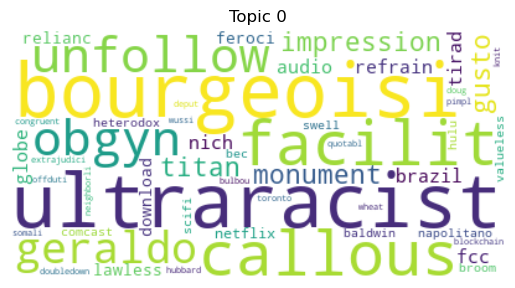

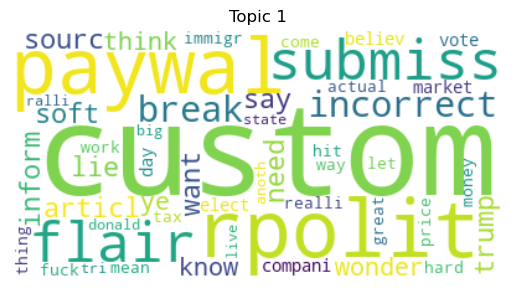

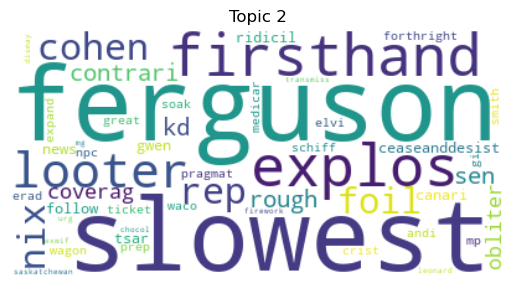

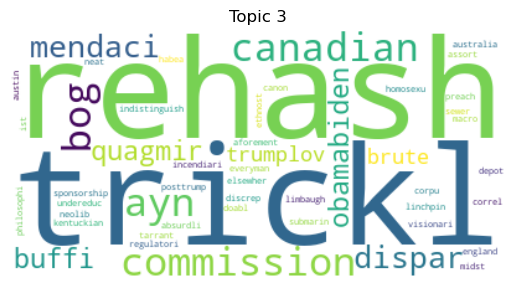

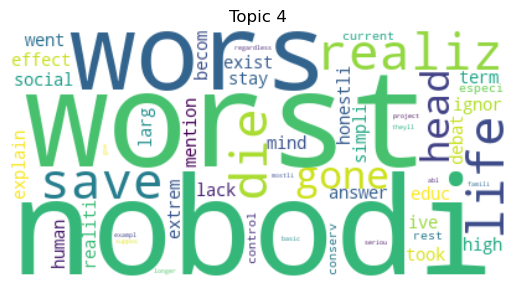

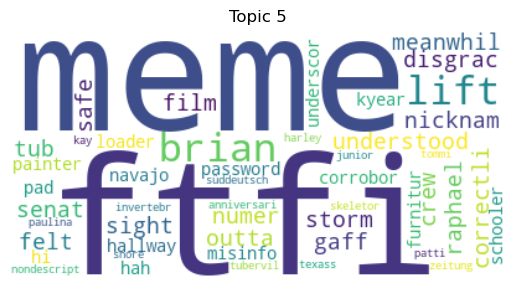

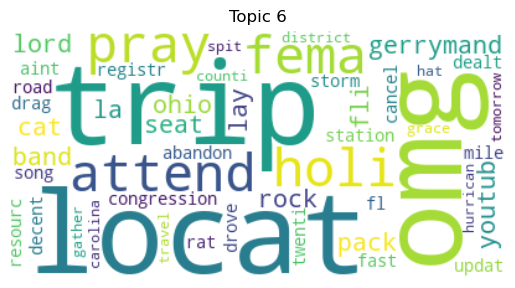

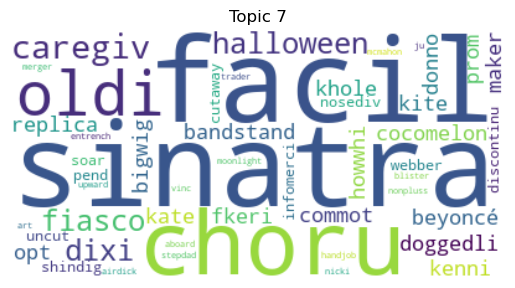

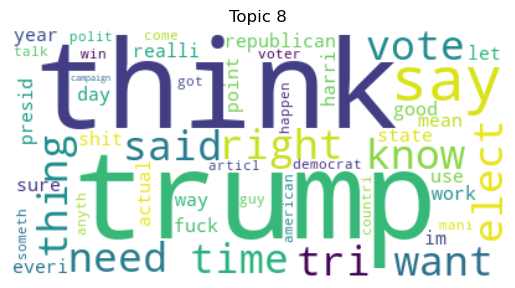

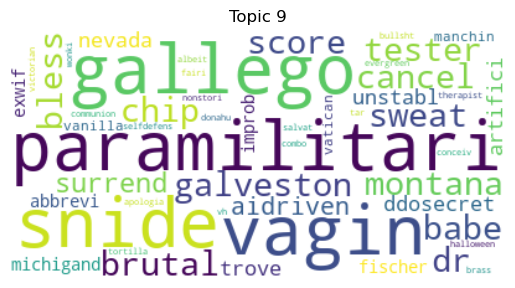

In [37]:
# Create a word cloud for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    wordcloud = WordCloud(background_color='white', max_words=100).generate(" ".join([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-50 - 1:-1]]))
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_idx}")
    plt.show()

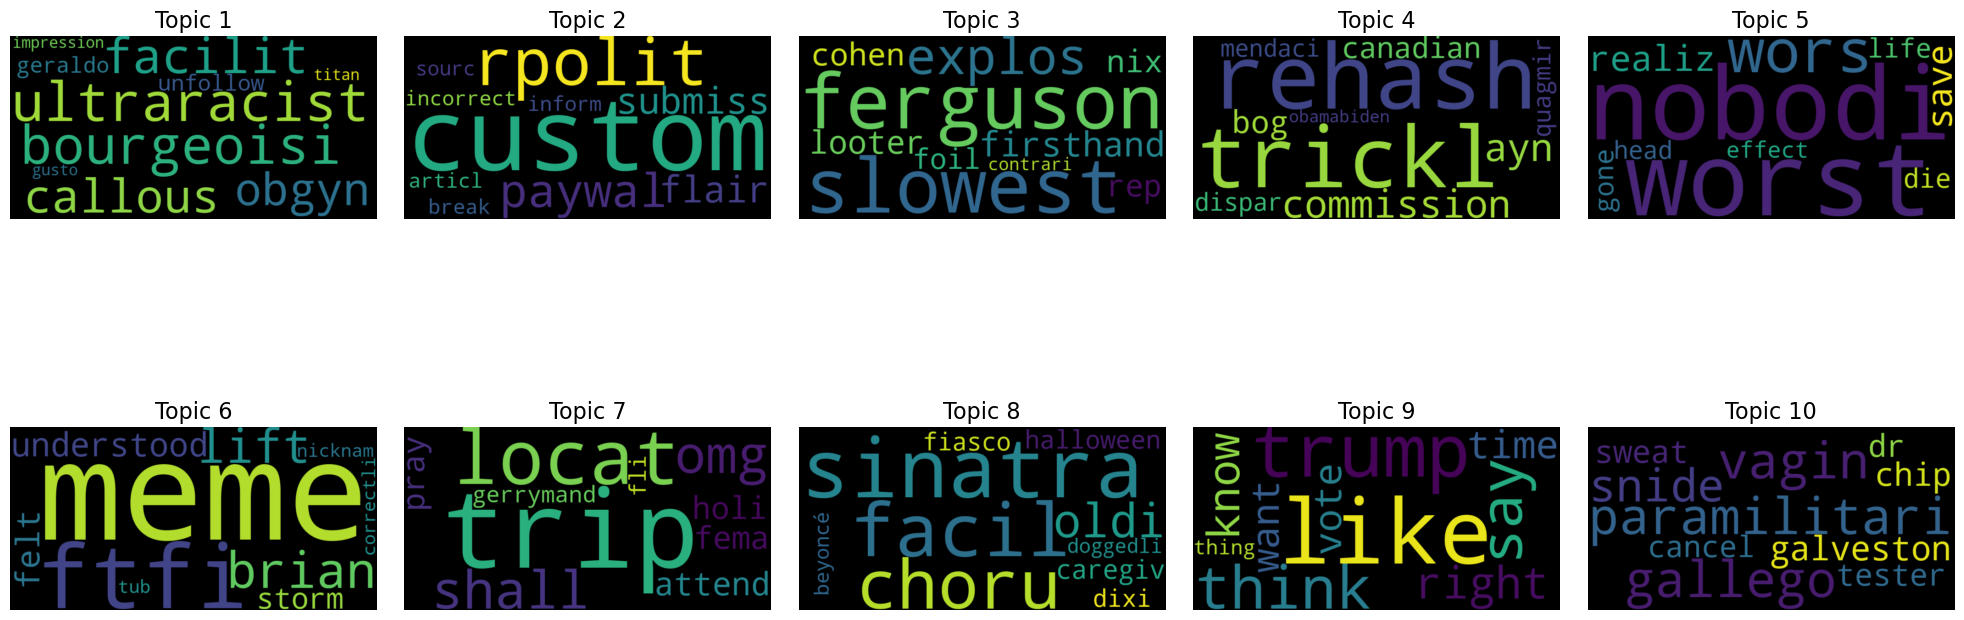

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_clouds(lda_model, feature_names, num_topics=10, num_words=10):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # Create a 2x5 grid
    axs = axs.flatten()

    for topic_idx, topic in enumerate(lda_model.components_[:num_topics]):
        # Generate the word cloud
        wordcloud = WordCloud(background_color='black', width=800, height=400, max_words=num_words)
        wordcloud_dict = {feature_names[i]: topic[i] for i in topic.argsort()[:-num_words-1:-1]}
        wordcloud.generate_from_frequencies(wordcloud_dict)

        # Plot the word cloud
        axs[topic_idx].imshow(wordcloud, interpolation='bilinear')
        axs[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=16)
        axs[topic_idx].axis('off')  # Turn off axis labels

    plt.tight_layout(pad=2)
    plt.show()

# Assuming 'lda_model' is your trained LDA model and 'vectorizer' is the CountVectorizer instance
plot_word_clouds(lda_model, vectorizer.get_feature_names_out(), num_topics=10, num_words=10)